# Softmax 练习

*补充并完成本练习。*

本练习类似于SVM练习，你要完成的事情包括:

- 为Softmax分类器实现完全矢量化的**损失函数**
- 实现其**解析梯度（analytic gradient）**的完全矢量化表达式
- 用数值梯度**检查你的代码**
- 使用验证集**调整学习率和正则化强度**
- 使用**SGD优化**损失函数
- **可视化**最终学习的权重


In [1]:
import random
import numpy as np
from daseCV.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'daseCV/datasets/cifar-10-batches-py'
    
    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax 分类器

请在**daseCV/classifiers/softmax.py**中完成本节的代码。

In [3]:
# 首先使用嵌套循环实现简单的softmax损失函数。
# 打开文件 daseCV/classifiers/softmax.py 并补充完成
# softmax_loss_naive 函数.

from daseCV.classifiers.softmax import softmax_loss_naive
import time

# 生成一个随机的softmax权重矩阵，并使用它来计算损失。
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.342726
sanity check: 2.302585


**问题 1**

为什么我们期望损失接近-log（0.1）？简要说明。

$\color{blue}{\textit 答:}$ 由于随机初始化了权值, 可以假设输出具有标准且独立的10维Dirichlet分布, 任选任一维, 其对数的期望是 $-\log(0.1)$, 根据大数定律, 样本均值随实验次数依概率收敛到 $-\log(0.1)$ . 

In [4]:
# 完成softmax_loss_naive，并实现使用嵌套循环的梯度的版本(naive)。
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# 就像SVM那样，请使用数值梯度检查作为调试工具。
# 数值梯度应接近分析梯度。
from daseCV.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# 与SVM情况类似，使用正则化进行另一个梯度检查
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: -2.905673 analytic: -2.905673, relative error: 1.302556e-08
numerical: -1.032551 analytic: -1.032551, relative error: 3.783352e-09
numerical: -2.449399 analytic: -2.449399, relative error: 5.190175e-09
numerical: 1.680700 analytic: 1.680700, relative error: 3.007103e-08
numerical: -1.416824 analytic: -1.416824, relative error: 2.140744e-08
numerical: -2.377110 analytic: -2.377110, relative error: 3.921314e-09
numerical: 0.723766 analytic: 0.723766, relative error: 3.076804e-08
numerical: 1.565534 analytic: 1.565534, relative error: 1.868199e-08
numerical: -3.543502 analytic: -3.543502, relative error: 1.560702e-08
numerical: -2.279167 analytic: -2.279167, relative error: 7.116745e-09
numerical: 0.580482 analytic: 0.580482, relative error: 4.811756e-08
numerical: -0.470891 analytic: -0.470891, relative error: 9.258663e-08
numerical: -1.380814 analytic: -1.380814, relative error: 1.180891e-10
numerical: -0.980213 analytic: -0.980213, relative error: 1.748217e-08
numerical: 0.6

In [5]:
# 现在，我们有了softmax损失函数及其梯度的简单实现，
# 接下来要在 softmax_loss_vectorized 中完成一个向量化版本.
# 这两个版本应计算出相同的结果，但矢量化版本应更快。
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from daseCV.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# 正如前面在SVM练习中所做的一样，我们使用Frobenius范数比较两个版本梯度。
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.342726e+00 computed in 0.003005s
vectorized loss: 2.342726e+00 computed in 0.004000s
Loss difference: 0.000000
Gradient difference: 0.000000


In [17]:
# 使用验证集调整超参数（正则化强度和学习率）。您应该尝试不同的学习率和正则化强度范围; 
# 如果您小心的话，您应该能够在验证集上获得超过0.35的精度。
from daseCV.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None
learning_rates = [1e-7, 2.5e-6, 5e-7]
regularization_strengths = [1e1, 1e2, 1e3]

################################################################################
# 需要完成的事:                                                                        
# 对验证集设置学习率和正则化强度。
# 这与之前SVM中做的类似；
# 保存训练效果最好的softmax分类器到best_softmax中。
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
import itertools
for lr, reg in itertools.product(learning_rates, regularization_strengths):
    softmax = Softmax()
    softmax.train(
        X_train, y_train, 
        learning_rate=lr, reg=reg, 
        num_iters=int(1500), 
        verbose=False
    )
    val_acc_rate = np.mean(softmax.predict(X_val) == y_val)
    trn_acc_rate = np.mean(softmax.predict(X_train) == y_train)
    results[(lr, reg)] = (trn_acc_rate, val_acc_rate)
    if val_acc_rate > best_val:
        best_val = val_acc_rate
        best_softmax = softmax
        print('new best', best_val)
# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))

print('best validation accuracy achieved during cross-validation: %f' % best_val)

new best 0.261
new best 0.271
new best 0.369
new best 0.388
new best 0.403
lr 1.000000e-07 reg 1.000000e+01 train accuracy: 0.247429 val accuracy: 0.261000
lr 1.000000e-07 reg 1.000000e+02 train accuracy: 0.248735 val accuracy: 0.255000
lr 1.000000e-07 reg 1.000000e+03 train accuracy: 0.269959 val accuracy: 0.271000
lr 5.000000e-07 reg 1.000000e+01 train accuracy: 0.318204 val accuracy: 0.319000
lr 5.000000e-07 reg 1.000000e+02 train accuracy: 0.329592 val accuracy: 0.321000
lr 5.000000e-07 reg 1.000000e+03 train accuracy: 0.384776 val accuracy: 0.402000
lr 2.500000e-06 reg 1.000000e+01 train accuracy: 0.385612 val accuracy: 0.369000
lr 2.500000e-06 reg 1.000000e+02 train accuracy: 0.400286 val accuracy: 0.388000
lr 2.500000e-06 reg 1.000000e+03 train accuracy: 0.393327 val accuracy: 0.403000
best validation accuracy achieved during cross-validation: 0.403000


In [18]:
# 在测试集上评估
# 在测试集上评估最好的softmax
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.383000


**问题 2** - *对或错*

假设总训练损失定义为所有训练样本中每个数据点损失的总和。
可能会有新的数据点添加到训练集中，同时SVM损失保持不变，但是对于Softmax分类器的损失而言，情况并非如此。

$\color{blue}{你的回答:}$

正确, SVM损失可能不变, 但Softmax损失一定变化. 

$\color{blue}{你的解释:}$

当该点被正确分类, 并处于Margin外时, SVM损失为零, 故总和不变. 
对Softmax来说, 对任一 $i$, $-log(e^{x_i}/Z)$ 的值总是大于零(其中 Z 表示归一化系数), 尽管它可能很小. 

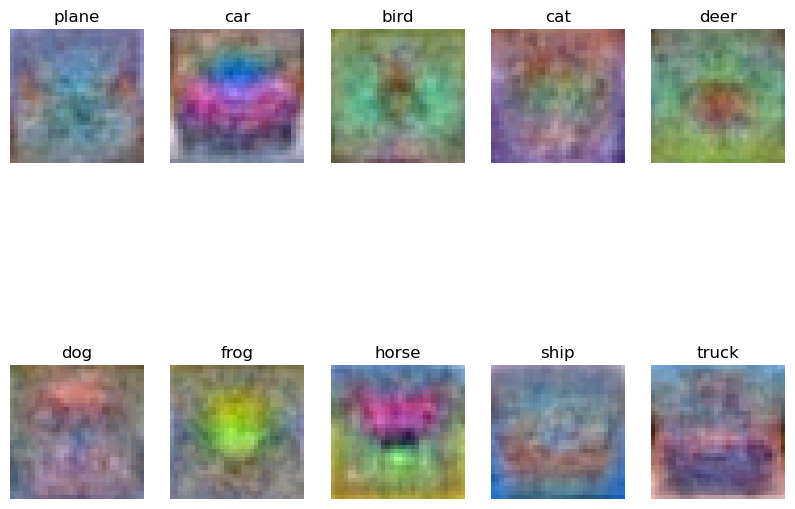

In [19]:
# 可视化每个类别的学习到的权重
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

### Data for leaderboard
这里额外提供了一组未给标签的测试集X，用于leaderborad上的竞赛。

---
提示：该题的目的是鼓励同学们探索能够提升模型性能的方法。

In [20]:
# leaderboard的测试数据
X = np.load("./input/X_3073.npy")
################################################################################
# 需要完成的事情: 
# 找到更合适的softmax
# 提示：如果你不想花时间，你也可以直接使用上面已经训练好的best_softmax。                   
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
softmax_leaderboard = best_softmax
preds = softmax_leaderboard.predict(X)

提醒：运行完下面代码之后，点击下面的submit，然后去leaderboard上查看你的成绩。本模型对应的成绩在phase3的leaderboard中。

In [21]:
import os
#输出格式
def output_file(preds, phase_id=3):
    path=os.getcwd()
    if not os.path.exists(path + '/output/phase_{}'.format(phase_id)):
        os.mkdir(path + '/output/phase_{}'.format(phase_id))
    path=path + '/output/phase_{}/prediction.npy'.format(phase_id)
    np.save(path,preds)
def zip_fun(phase_id=3):
    path=os.getcwd()
    output_path = path + '/output'
    files = os.listdir(output_path)
    for _file in files:
        if _file.find('zip') != -1:
            os.remove(output_path + '/' + _file)
    newpath=path+'/output/phase_{}'.format(phase_id)
    os.chdir(newpath)
    cmd = 'zip ../prediction_phase_{}.zip prediction.npy'.format(phase_id)
    os.system(cmd)
    os.chdir(path)
output_file(preds)
zip_fun()